# (ADA) Homework 1: Scoring the Language Model Olympics

In [2768]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind
import seaborn as sns

## Task 1 (18 points): What's in an average anyway?

### 1.1 (1 pt)
 
Load the subfiles contained in the `mmlu_data` and `lm_scores` folders into separate dataframes:
- `df_test`
- `df_x`
- `df_y`
- `df_z`

for each, print their sizes.

In [2769]:
# load csv files
df_test = pd.read_csv('task_1/mmlu_data/test.csv')
df_x = pd.read_csv('./task_1/lm_scores/lm_X.csv')
df_y = pd.read_csv('./task_1/lm_scores/lm_Y.csv')
df_z = pd.read_csv('./task_1/lm_scores/lm_Z.csv')

# print their size
print('Size of df_test : ' + str(df_test.shape))
print('Size of df_x : ' + str(df_x.shape))
print('Size of df_y : ' + str(df_y.shape))
print('Size of df_z : ' + str(df_z.shape))

Size of df_test : (14042, 8)
Size of df_x : (13882, 2)
Size of df_y : (13978, 2)
Size of df_z : (13923, 2)


##We can see that for LM X, Y and Z, they all show different shapes, possibly explained by skipped questions.

### 1.2 (4 pt)
Unfortunately, LMs don't always output the format we want. In the column `result`, the value should be one of A, B, C, or D. 

#### Part A (Code)
For each of the LM score dataframes, use a `value_counts()` operation and print the results. 

In [2770]:
#A
def print_sorted_value_counts(df, LM_name):
    # compute value counts and convert to dictionary
    value_counts_df = df['result'].value_counts().to_dict()
    # sort them by the length of characters 
    sorted_value_counts_df = sorted(value_counts_df.items(), key = lambda a: len(str(a[0])))
    # print the first 25 most common types of answer in sorter_value_counts_df
    print(f"Sorted value counts for {LM_name}:\n")
    for i, value in sorted_value_counts_df[:25]: # take off the '[:25]' to inspect the full dataframe
        print(f"{i}: {value}")
    print("\n\n----------------------------------------------\n\n")

# call the function "print_sorted_value_counts" for each lm
print_sorted_value_counts(df_x, "LM X")
print_sorted_value_counts(df_y, "LM Y")
print_sorted_value_counts(df_z, "LM Z")

Sorted value counts for LM X:

A: 2733
B: 1412
C: 1134
D: 1124
A : 1657
B : 793
C : 622
D : 596
Not Sure: 73
Answer: A: 1398
Answer: B: 760
Answer: D: 613
Answer: C: 594
None of the above: 69
5, so the answer is A: 1
3, so the answer is B: 1
No, so the answer is B: 1
13, so the answer is C: 1
10%, so the answer is A: 1
80%, so the answer is C: 1
Paris, so the answer is A: 1
white, so the answer is C: 1
China, so the answer is D: 1
C =8π, so the answer is B: 1
6.68%, so the answer is D: 1


----------------------------------------------


Sorted value counts for LM Y:

D: 2894
C: 1701
B: 1240
A: 1008
D : 1145
C : 634
B : 553
A : 428
Not Sure: 86
Answer: D: 1718
Answer: C: 907
Answer: B: 726
Answer: A: 597
None of the above: 66
6, so the answer is A: 1
5, so the answer is A: 1
4, so the answer is D: 1
40, so the answer is D: 1
PET, so the answer is C: 1
309, so the answer is B: 1
H2O, so the answer is B: 1
20%, so the answer is B: 1
legs, so the answer is D: 1
NATO, so the answer is D: 1

##This allows us to clearly see the most common answers (detailed below) directly for further analysis. Defining a function allows us to recall it later on if needed and be able to use it with other potential datasets.

#### Part B (Discussion)
**Inspect the results and describe the types of answer formats you see. Besides the "expected" case, you should be able to find at least four unexpected formats.**

By sorting the answers by length of character, we see besides the expected answers A,B, C, D and several other answers. They fall into some main categories(here A is used as example but applies to B, C and D too):
1) Similar to expected answer, but with the addition of one or more spaces (e.g 'A ' instead of 'A')
2) Formatted as 'Answer: A' instead of 'A'
3) Answers including a text explanation/reasoning and then the answer (e.g. "Some explanation... so answer is A" instead of A, or variations around that format)
4) 'Not Sure' answer
5) 'None of the above' answer

And by manually inspecting the data (also hinted by the differences on sizes in Part 1.1) :
6) It doesn't answer at all, and leaves it blank

### 1.3 (5 pt)
Oh oh... That doesn't look great. Simply dropping all invalid answers seems overly wasteful, yet fixing all of these looks like a mess! Instead, let's focus for now on fixing just those answers of length < 10 characters that require only a single `str.replace()` operation. 

For example, if the answer looks like `--A--`, we could fix this by using the following simple function:

```
def clean_answer(s, pattern='-'):
    return str(s).replace(pattern, '')

dirty_answer = '--A--'
clean_answer = clean_answer(dirty_answer)
```

#### Part A (Code)
Filter the three score dataframes to include only answers with less than 10 characters. Make a deep copy of the dataframes as you filter them.

In [2771]:
#A
# filter the answers shorter than 10 characters and create the deep copies
df_x_filtered = df_x.loc[df_x["result"].str.len()<10].copy(deep=True)
df_y_filtered = df_y.loc[df_y["result"].str.len()<10].copy(deep=True)
df_z_filtered = df_z.loc[df_z["result"].str.len()<10].copy(deep=True)

# check their content by reusing the print_sorted_value_counts function
print_sorted_value_counts(df_x_filtered, "df_x")
print_sorted_value_counts(df_y_filtered, "df_y")
print_sorted_value_counts(df_z_filtered, "df_z")

Sorted value counts for df_x:

A: 2733
B: 1412
C: 1134
D: 1124
A : 1657
B : 793
C : 622
D : 596
Not Sure: 73
Answer: A: 1398
Answer: B: 760
Answer: D: 613
Answer: C: 594


----------------------------------------------


Sorted value counts for df_y:

D: 2894
C: 1701
B: 1240
A: 1008
D : 1145
C : 634
B : 553
A : 428
Not Sure: 86
Answer: D: 1718
Answer: C: 907
Answer: B: 726
Answer: A: 597


----------------------------------------------


Sorted value counts for df_z:

D: 2257
C: 2191
B: 2127
A: 2060
C : 316
D : 314
B : 285
A : 279
Not Sure: 125
Answer: D: 777
Answer: C: 748
Answer: B: 712
Answer: A: 687


----------------------------------------------




##Here, we filter the rows of the 'result' column of each LM to discard every answer longer than 9 characters and then create deep copies to ensure no consequences on our original data. Then, we recall our function "print_sorted_value_counts" from earlier and we see < 25 prints per dataframe meaning that we see the whole dataframe. Here, we see that there are spaces to take off, 'Not Sure' answers to discard and also "Answer: A" to clean (take off 'Answer ').

#### Part B (Code)
Modify the `clean_answer()` example function to clean the answers in the filtered data frames using the `apply()` functionality. Finally, make sure **all remaining answers are one of `A, B, C, or D`.**

In [2772]:
#B
# clean the results colums of the dataframe (here, we transform 'Answer: X' and 'X ' to be 'X')
def clean_answer(s, pattern='Answer: '):
    newstr = str(s).replace(pattern, '') # replace all answers of the form 'Answer: X' into 'X'
    newstr = str(newstr).replace(' ','') # remove all spaces
    return newstr

# apply the function to replace 'Answer: X' and remove spaces for each filtered dataframe 
df_x_filtered.result = df_x_filtered.result.apply(lambda a : clean_answer(a)) 
df_y_filtered.result = df_y_filtered.result.apply(lambda a : clean_answer(a))
df_z_filtered.result = df_z_filtered.result.apply(lambda a : clean_answer(a))

# removing all 'NotSure' (now that all spaces have been removed) answers for each filtered and cleaned dataframe
df_x_cleaned = df_x_filtered.loc[df_x_filtered.result!='NotSure']
df_y_cleaned = df_y_filtered.loc[df_y_filtered.result!='NotSure']
df_z_cleaned = df_z_filtered.loc[df_z_filtered.result!='NotSure']

# function to print the newly cleaned dataframes and show further information like the total information discarded from filtering and cleaning
def print_cleaned_df_informations(old_df, new_df, LM_name):
    print('For ' + LM_name + ' :') 
    print(new_df['result'].value_counts().to_string(header=False)) # print the value count of the cleaned and filtered dataframe
    print('Original size: %d' % old_df.shape[0]) # print original size of the dataframe
    print('Clean data size: %d' % new_df.shape[0]) # display size of the dataframe after cleaning and filtering
    print('Data removed: %d' % (old_df.shape[0]-new_df.shape[0])) # compute amout of data removed
    print('Data removed in percents:', round((100*(old_df.shape[0]-new_df.shape[0])/old_df.shape[0]),2), '%\n') # compute percentage of original data removed in %

# use the function 'print_cleaned_df_informations'
print_cleaned_df_informations(df_x, df_x_cleaned, 'LM X')
print_cleaned_df_informations(df_y, df_y_cleaned, 'LM Y')
print_cleaned_df_informations(df_z, df_z_cleaned, 'LM Z')

For LM X :
A    5788
B    2965
C    2350
D    2333
Original size: 13882
Clean data size: 13436
Data removed: 446
Data removed in percents: 3.21 %

For LM Y :
D    5757
C    3242
B    2519
A    2033
Original size: 13978
Clean data size: 13551
Data removed: 427
Data removed in percents: 3.05 %

For LM Z :
D    3348
C    3255
B    3124
A    3026
Original size: 13923
Clean data size: 12753
Data removed: 1170
Data removed in percents: 8.4 %



##Here, we used the function provided "clean_answer()" to keep as much data as possible to transform 'Answer: X' and 'X ' to 'X' so we can more easily do further analysis. Then, we removed the unwanted answers "Not Sure" and printed the value counts of the newly cleaned dataframe and the amount of information removed from the filtering (<10) and the cleaning in numbers and in %. 

##Note that we could have filtered differently to keep more usefull data in our cleaned dataframe by not filtering by length <10. Indeed, after looking at the data on Part 1.2 (Part A), we can see that we could have discarded the data more intelligentely as everytime the LM answers with a long answer (>10 characters), its answer always ends with 'A', 'B', 'C' or 'D' which means we could have used this information to filter more wisely, without too much effort (SQL allows that very easily). We then would have to also think about taking off 'None of the above' answers in addition to the 'Not Sure'.

#### Part B (Discussion)
**Compare the sizes of the original and filtered data frames. What do you see? Why might this be a problem?**



We see that for the datasets, the amount of data that gets discarded is important. Especially for dataset of LM Z, where 8.4% of the data gets discarded (the other two are around 3% discarded data). That might be unfair to all LMs,  (even more to LM Z where more data gets discarded) if the data that gets discarded does not have the same distribution than the remaining data. This could result in wrong results and also poorer performance for LM Z compared to LM X and LM Y.

This discarded data can be a problem as these data are part of our study. They aren't not in the sense or format we expect for this analysis and it's why we filtered them, but they remain data generated by the models we are investigating and they shouldn't be simply ignored. The decision of ignoring them should at least involve thinking about them and mention their exclusion.

### 1.4 (3 pt)
Now that our answer columns are nicely formatted, let's take a look at model performance:

#### Part A (Code)
Both the `MMLU` dataframes and the language model score data frames have the columns `question_id`. For each of the language model score data frames, use an inner join operation with the `df_test` dataframe on the `question_id` column.

In [2773]:
#A
# do the inner join operation on the 'question_id' column
df_x_joined = pd.merge(df_x_cleaned,df_test, left_on='question_id', right_on='question_id')
df_y_joined = pd.merge(df_y_cleaned,df_test, left_on='question_id', right_on='question_id')
df_z_joined = pd.merge(df_z_cleaned,df_test, left_on='question_id', right_on='question_id')

#### Part B (Code)
Add a new column to each of the resulting dataframes called `correct`, that checks if the model's answer in `result` is the same as the expected answer in the column `answer`. Then, print the average score of each model.

In [2774]:
#B
# adds to the dataframe a new column called 'correct' booleans (True if LM answered correctly, False otherwise) and then prints the scores of the LM 
def print_scores (df_joined, LM_name):
    df_joined['correct'] = df_joined['result'] == df_joined['answer'] # creates a 'correct' column that possesses a boolean (True if the string in the 'result' column matches the 'answer' column, False otherwise)
    nb_true = df_joined.loc[df_joined['correct'] == True].correct.count()  # counts the number of True in newly created 'correct' column
    nb_false = df_joined.loc[df_joined['correct'] == False].correct.count()  # counts the number of False in newly created 'correct' column
    print('\n' + LM_name + ' : True = %d, False = %d' % (nb_true, nb_false)) # print the counts of True and False

    df_score = df_joined['correct'].mean()  # computes the mean of the True/False values (True = 1, False = 0)
    print('Score : %.4f' % df_score) 

# use print_score() function
print_scores(df_x_joined, 'LM X')
print_scores(df_y_joined, 'LM Y')
print_scores(df_z_joined, 'LM Z')


LM X : True = 10312, False = 3124
Score : 0.7675

LM Y : True = 10107, False = 3444
Score : 0.7458

LM Z : True = 8459, False = 4294
Score : 0.6633


##We can see that the Language Model Z (66%) performs less well than the two others (~75%) by 10% which could indicate some unbalance. This could result from the 8.4% of removed data on the dataframe of LM Z compared to 3% removed for the dataframes of LM X and Y or could also result from the subjects of the questions (detailed below).

### 1.5 (5 pt)

Hmmm, something doesn't seem quite right. Let's investigate how "balanced" this dataset is:

#### Part A (Code)
For each of the 57 subjects in the MMLU, compare the number of questions answered by each model. Print the subjects for which there is a more than 10% difference.

**hint:**
- For a given subject, let model X and model Y have answered 181 and 200 questions respectively. You can consider this a 10% difference from the perspective of X since: (200 - 181) / 181 > 0.10

In [2775]:
# A
# group data by 'subject' and count the number of questions of each subject 
df_x_by_subj = df_x_joined.groupby(by='subject').count().result
df_y_by_subj = df_y_joined.groupby(by='subject').count().result
df_z_by_subj = df_z_joined.groupby(by='subject').count().result

# merge the counts of answers for each subject into a single dataframe
subjects = pd.merge(df_x_by_subj, df_y_by_subj, left_index=True, right_index=True)
subjects = pd.merge(subjects, df_z_by_subj, left_index=True, right_index=True)

#each column represents the number of answers for each subject by model
subjects.columns = ['Answers_x', 'Answers_y', 'Answers_z']

# function to compute the percentage difference between two models, for a given subject
def compute_differences(data, model_1, model_2):
    return np.abs(data[model_1] - data[model_2])/np.minimum(data[model_1], data[model_2]) *100 # multiplies by 100 to get the %

# see subjects where the answer counts for the models with more than 10% differences
subjects_unbalanced = subjects.loc[(compute_differences(subjects, 'Answers_x', 'Answers_y') > 10) | 
                                   (compute_differences(subjects, 'Answers_y', 'Answers_z') > 10) | 
                                   (compute_differences(subjects, 'Answers_x', 'Answers_z') > 10)]

# display the table with the unbalanced subjects
subjects_unbalanced

,Answers_x,Answers_y,Answers_z
subject,,,
college chemistry,96,98,84
college computer science,97,98,84
computer security,95,98,87
formal logic,109,123,113
high school geography,195,193,176
logical fallacies,154,136,147
medical genetics,97,98,89
moral disputes,329,304,250
moral scenarios,737,865,774


##We can see that there are 9 subjects that might unbalance the results. Further investigation is needed to see if this really has an impact or not on the overall scores.

#### Part B (Code)
Propose and implement a reasonable way to rebalance the results. (e.g., while throwing away 100% of the results perfectly rebalances the results, it is not reasonable).

In [2776]:
#B

# store scores of each LM before balancing the df_x_joined dataframe in order to compare later on
avg_score_x = df_x_joined['correct'].mean()*100
avg_score_y = df_y_joined['correct'].mean()*100
avg_score_z = df_z_joined['correct'].mean()*100


# randomly remove excess values from the datasets, to match the number of value of the dataset with less values

# loop trough each subject in the dataframe containing unbalanced subjects 
for subject_name in subjects_unbalanced.index:

     # finds the smallest number of correct answers among Answers_x, Answers_y and Answers_z for the current subject
    target_size = min(subjects_unbalanced.loc[subject_name, ["Answers_x","Answers_y","Answers_z"]]) 

    # find how many questions to remove from model x based on the difference between its count and the target_size
    n_data_to_remove_x = subjects_unbalanced.loc[subject_name, "Answers_x"]-target_size
    # sample n random indices to remove from model x
    idx_to_remove_x = df_x_joined.loc[df_x_joined.subject==subject_name].sample(n=n_data_to_remove_x).index
    # remove the selected rows from model x
    df_x_joined = df_x_joined.drop(idx_to_remove_x,axis=0)

    # repeat the process for model y   
    n_data_to_remove_y = subjects_unbalanced.loc[subject_name, "Answers_y"]-target_size
    idx_to_remove_y = df_y_joined.loc[df_y_joined.subject==subject_name].sample(n=n_data_to_remove_y).index
    df_y_joined = df_y_joined.drop(idx_to_remove_y,axis=0)

    # repeat the process for model z
    n_data_to_remove_z = subjects_unbalanced.loc[subject_name, "Answers_z"]-target_size
    idx_to_remove_z = df_z_joined.loc[df_z_joined.subject==subject_name].sample(n=n_data_to_remove_z).index
    df_z_joined = df_z_joined.drop(idx_to_remove_z,axis=0)

#### Part C (Code)
Finally, print the updated accuracy on the rebalanced data.

In [2777]:
#C

# print the new count of True and False for each LM after balancing them and print the old score and the new score for comparison
def print_and_compare_joined_vs_balanced(df_join, old_avg_score, LM_name):
    print('\nNew results of ' + LM_name + ' : ')
    print('True = %d, False = %d' % (df_join.loc[df_join.correct==True].correct.count(), df_join.loc[df_join.correct==False].correct.count()))
    print('Old Average Score : ' + str(round(old_avg_score, 2)) + '%')
    new_avg_score = df_join['correct'].mean()*100
    print('New Average Score : ' + str(round(new_avg_score, 2)) + '%')

# displays for comparison and takes avg_score_x/y/z which is the score of LM X/Y/Z before the balancing
print_and_compare_joined_vs_balanced(df_x_joined, avg_score_x, 'LM X')
print_and_compare_joined_vs_balanced(df_y_joined, avg_score_y, 'LM Y')
print_and_compare_joined_vs_balanced(df_z_joined, avg_score_z, 'LM Z')


New results of LM X : 
True = 10198, False = 3081
Old Average Score : 76.75%
New Average Score : 76.8%

New results of LM Y : 
True = 9922, False = 3368
Old Average Score : 74.58%
New Average Score : 74.66%

New results of LM Z : 


True = 8424, False = 4277
Old Average Score : 66.33%
New Average Score : 66.33%


##Here, we see that correcting the unbalance does not change the scores of the LM in significant way (<0.1% every time), confirming no clear influence of these subjects on the LM performance.

## Task 2 (26 points): What do you mean A > D > B > C...?

Nice work! Having successfully inspected, cleaned, and rebalanced the provided data, you head over to director of the government's NEUTRALITY project. Ms. Sakota is happy with your work so far, but worried that the sloppy intern might have done more undetected damage. To be sure, she orders a new set of evaluations of all models on both MMLU and another dataset.

After cleaning up and rebalancing, you are left with the concatenated score files in the second folder `task_2`:
```
task_2/
│
└── lm_scores_mmlu.csv
│
└── lm_scores_other.csv
```

Each has a new column called `model_name`, which is one of `X, Y` or `Z`.



_NOTE: **only** use data from `task_2` and `task_2_5` for this assignment! The values in `lm_scores_mmlu.csv` will NOT be the same as the dataframes you finished in task 1. This is due to "randomness" or "temperature" in language model inference. This can slightly shift around generative results. (Conveniently: it also ensures any mistakes made in Task 1 don't propogate further ;) )_

In [2778]:
# PROVIDED CODE
df_mmlu = pd.read_csv('task_2/lm_scores_mmlu.csv')
df_other = pd.read_csv('task_2/lm_scores_other.csv')

### 2.1 (4 pt)

Let's explore the new results:

#### Part A (Code)
Compute the mean accuracy and standard errors of each model on both datasets and print the results.

In [2779]:
#A
# mean and standard error for each LM
def compute_mean_and_std(df):
    mean_accuracy = df.groupby('model_name')['correct'].mean()
    standard_error = df.groupby('model_name')['correct'].sem()
    return mean_accuracy, standard_error

# mean and standard error for mmlu and other dataset
mmlu_mean, mmlu_std = compute_mean_and_std(df_mmlu)
other_mean, other_std = compute_mean_and_std(df_other)

# table for mmlu dataset
mmlu_table = pd.DataFrame({
    'Model Name': mmlu_mean.index,
    'Mean Accuracy': mmlu_mean.round(5).values,
    'Std Error': mmlu_std.round(7).values
})

# table for other dataset
other_table = pd.DataFrame({
    'Model Name': other_mean.index,
    'Mean Accuracy': other_mean.round(5).values,
    'Std Error': other_std.round(7).values
})

# print results in table
print("MMLU Dataset :")
print(mmlu_table.to_string(index=False))

print("\n\nOther Dataset :")
print(other_table.to_string(index=False))

MMLU Dataset :
Model Name  Mean Accuracy  Std Error
         X        0.74359   0.004038
         Y        0.76154   0.003941
         Z        0.65595   0.004393


Other Dataset :
Model Name  Mean Accuracy  Std Error
         X        0.78798   0.006668
         Y        0.72094   0.007317
         Z        0.67172   0.007660


##We observe very low standard errors for each LM for each dataset.

#### Part B (Code)
Then, show your results in a bar plot using standard errors with a 95% confidence interval around the mean. Make sure the plot is easy to read and well annotated.

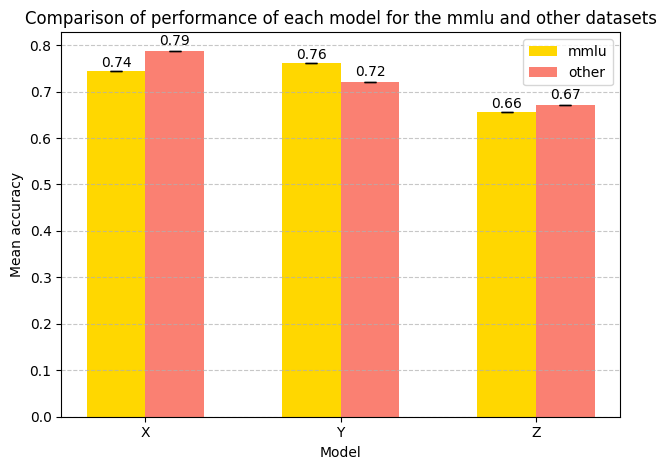

In [2780]:
#B
# bar plot with error bars with 95% confidence interval
models = ['X', 'Y', 'Z']
x = np.arange(len(models))
bar_width = 0.3

# figure and axis
fig, ax = plt.subplots()
# bar plots for the mmlu dataset and other datasets
ax.bar(x - bar_width/2, mmlu_mean, bar_width, yerr = 1.96*mmlu_std/np.sqrt(len(df_mmlu)/3), label = 'mmlu', capsize = 4, color='gold') # also displays error bars, using the formula 1.96*std/sqrt(n)
ax.bar(x + bar_width/2, other_mean, bar_width, yerr = 1.96*other_std/np.sqrt(len(df_other)/3), label = 'other', capsize = 4, color='salmon')

# show labels, titles and ticks
ax.set_title('Comparison of performance of each model for the mmlu and other datasets')
ax.set_xlabel('Model')
ax.set_ylabel('Mean accuracy')
ax.set_xticks(x)
ax.grid(axis='y',linestyle='--',alpha=0.7)
ax.set_xticklabels(models)
ax.legend()

# display the confidence intervals
for i in range(len(models)):

    # use .iloc[] for positional indexing to avoid "FutureWarning"
    ax.text(x[i] - bar_width/2, mmlu_mean.iloc[i] + mmlu_std.iloc[i] + 0.005, f'{mmlu_mean.iloc[i]:.2f}', ha='center', color='black')
    ax.text(x[i] + bar_width/2, other_mean.iloc[i] + other_std.iloc[i] + 0.005, f'{other_mean.iloc[i]:.2f}', ha='center', color='black')

# show the plot
plt.tight_layout()
plt.show()

##We observe very low error bars, which is expected from very low standard erros (2.1).

#### Part C (Discussion)
**(i) Can you say that one of the models is the best?**

Not really, we only know that overall Model Z performs poorly compared to Model X and Y but since Model Y has higher performance on the 'mmlu dataset' (with small enough error bars --> does not reach 0.74) than X and Model X has higher performance on the 'other dataset' we can not distinguish which one is better. Although one might argue that Model X has higher performance on average, which could make it the best of the three but further tests should be made in order to confirm this hypothesis.

**(ii) Is there anything that seems odd?**

Yes, the fact that Model X and Y have such variations on their performance (4-5%) is odd. This would mean that these Models are more fit to answer to specific subjects. For example, Model X performed better on the 'other' dataset compared to the 'mmlu' dataset which means that the 'other' dataset contained fitter subjects for Model X.

Also, Model Z seemed to really under-perform compared to the other two Models but does not show any significant change in performance across the two datasets (mmlu and other), maybe indicating that this Model doesn't specialise as much as the other two models.

### 2.2 (5 pt)

Ms. Sakota has assured you that both datasets contain questions of similar difficulty, so, what could be going on here?

#### Part A (Code)
What is the distribution of correct answers (A, B, C, D) for each dataset? Create a bar chart to visualize this.

**hints:**
- Keep in mind that df_mmlu and df_other contain the results of all models, i.e., the `question_id` column is duplicated.
- Take care to clearly annotate the bar chart, e.g., title, y-label, legend.

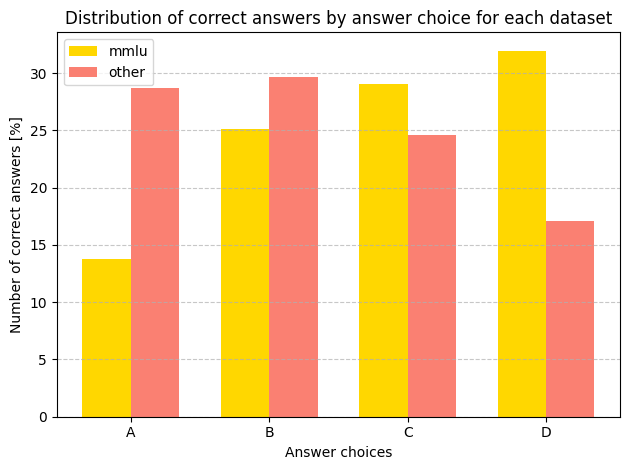

In [2781]:
# A

# count number of correct answers for option 'A', 'B', 'C', 'D' in the mmlu dataset
# 'drop_duplicates' makes sures that only one instance per unique 'question_id' is counted
# divided by drop_duplicates(subset=['question_id']).shape[0] to get the proportions
correct_answers_A_mmlu = len(df_mmlu.loc[df_mmlu['answer']=='A'].drop_duplicates(subset=['question_id']))*100/df_mmlu.drop_duplicates(subset=['question_id']).shape[0]
correct_answers_B_mmlu = len(df_mmlu.loc[df_mmlu['answer']=='B'].drop_duplicates(subset=['question_id']))*100/df_mmlu.drop_duplicates(subset=['question_id']).shape[0]
correct_answers_C_mmlu = len(df_mmlu.loc[df_mmlu['answer']=='C'].drop_duplicates(subset=['question_id']))*100/df_mmlu.drop_duplicates(subset=['question_id']).shape[0]
correct_answers_D_mmlu = len(df_mmlu.loc[df_mmlu['answer']=='D'].drop_duplicates(subset=['question_id']))*100/df_mmlu.drop_duplicates(subset=['question_id']).shape[0]

# same but for the other dataset
correct_answers_A_other = len(df_other.loc[df_other['answer']=='A'].drop_duplicates(subset=['question_id']))*100/df_other.drop_duplicates(subset=['question_id']).shape[0]
correct_answers_B_other = len(df_other.loc[df_other['answer']=='B'].drop_duplicates(subset=['question_id']))*100/df_other.drop_duplicates(subset=['question_id']).shape[0]
correct_answers_C_other = len(df_other.loc[df_other['answer']=='C'].drop_duplicates(subset=['question_id']))*100/df_other.drop_duplicates(subset=['question_id']).shape[0]
correct_answers_D_other = len(df_other.loc[df_other['answer']=='D'].drop_duplicates(subset=['question_id']))*100/df_other.drop_duplicates(subset=['question_id']).shape[0]

# store the counts of correct answers for mmlu and other dataset in a list
correct_answers_mmlu = [correct_answers_A_mmlu, correct_answers_B_mmlu, correct_answers_C_mmlu, correct_answers_D_mmlu]
correct_answers_other = [correct_answers_A_other, correct_answers_B_other, correct_answers_C_other, correct_answers_D_other]

categories = ['A', 'B', 'C', 'D']
bar_width = 0.35

# set up the bar chart
fig, ax = plt.subplots()

# bar positions
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# plotting both MMLU and Other sets
bars1 = ax.bar(r1, correct_answers_mmlu, color='gold', width=bar_width, label='mmlu')
bars2 = ax.bar(r2, correct_answers_other, color='salmon', width=bar_width, label='other')

# labels and title
ax.set_xlabel('Answer choices')
ax.set_ylabel('Number of correct answers [%]')
ax.set_title('Distribution of correct answers by answer choice for each dataset')
ax.set_xticks([r + bar_width/2 for r in r1])
ax.grid(axis='y',linestyle='--',alpha=0.7)
ax.set_xticklabels(categories)
ax.legend()

# show plot
plt.tight_layout()
plt.show()

#### Part B (Code & Discussion)
Perform a chi-square test at $\alpha = 0.05$, of independence to determine if there's a significant difference in the distribution of correct answers between the two datasets. 

**hint:**
- clearly state the null hypothesis and alternative hypothesis
- use the `chi2_contingency` function from `scipy.stats`
- format your results from answer (A) as a 2D array

In [2782]:
#B

# to do the dataframe below
correct_answers_A_mmlu = len(df_mmlu.loc[df_mmlu['answer']=='A'].drop_duplicates(subset=['question_id']))
correct_answers_B_mmlu = len(df_mmlu.loc[df_mmlu['answer']=='B'].drop_duplicates(subset=['question_id']))
correct_answers_C_mmlu = len(df_mmlu.loc[df_mmlu['answer']=='C'].drop_duplicates(subset=['question_id']))
correct_answers_D_mmlu = len(df_mmlu.loc[df_mmlu['answer']=='D'].drop_duplicates(subset=['question_id']))
correct_answers_A_other = len(df_other.loc[df_other['answer']=='A'].drop_duplicates(subset=['question_id']))
correct_answers_B_other = len(df_other.loc[df_other['answer']=='B'].drop_duplicates(subset=['question_id']))
correct_answers_C_other = len(df_other.loc[df_other['answer']=='C'].drop_duplicates(subset=['question_id']))
correct_answers_D_other = len(df_other.loc[df_other['answer']=='D'].drop_duplicates(subset=['question_id']))

# combine results in one dataframe for the two datasets
results_df_combined = pd.DataFrame({
    'Dataset': ['A', 'B', 'C', 'D'] * 2,
    'Distribution': [correct_answers_A_mmlu, correct_answers_B_mmlu, correct_answers_C_mmlu, correct_answers_D_mmlu, correct_answers_A_other, correct_answers_B_other, correct_answers_C_other, correct_answers_D_other],
    'Source': ['mmlu'] * 4 + ['other'] * 4
})

from scipy.stats import chi2_contingency

#chi2 test of the distribtuion of correct answers between the two datasets
array_dist = np.array([results_df_combined['Distribution'].values[:4], results_df_combined['Distribution'].values[-4:]])
res = chi2_contingency(array_dist)
print('p-value = ', res.pvalue)

p-value =  4.270849602795191e-136


**What do you conclude?**

- Null hypothesis : the distribution of correct answers between each dataset is the same 
- ⁠Alternative hypothesis : the distribution of corr. answers are different between each dataset

Here, as the pvalue (~4.27E-136) is smaller than 0.05, we reject the null hypothesis. The very small p-value means that the distribution can't be the same between the two dataset.

### 2.3 (7 pt)

Let's dive in deeper:

#### Part A (Code)
What is language model X's mean accuracy conditioned on the four answer options for each dataset?

In [2783]:
#A
# create a new df panda with model X's answers for each dataset
model_X_mmlu = df_mmlu.loc[df_mmlu['model_name']=='X']
model_X_other = df_other.loc[df_other['model_name']=='X']

# for dataset 'mmlu', print the mean accuracies conditioned on the four answer options 
print('MMLU dataset:')
for answer in ['A', 'B', 'C', 'D']:
    model_X_mmlu_answer = model_X_mmlu.loc[model_X_mmlu['answer'] == answer]
    true_count = model_X_mmlu_answer['correct'].sum() 
    print(f'{answer} = ',round(true_count / len(model_X_mmlu_answer), 3))

# for dataset 'other', print the mean accuracies conditioned on the four answer options 
print('\n\nOthers dataset:')
for answer in ['A', 'B', 'C', 'D']:
    model_X_other_answer = model_X_other.loc[model_X_other['answer'] == answer]
    true_count = model_X_other_answer['correct'].sum()
    print(f'{answer} = ',round(true_count / len(model_X_other_answer), 3))


MMLU dataset:
A =  0.973
B =  0.799
C =  0.708
D =  0.634


Others dataset:
A =  0.974
B =  0.806
C =  0.676
D =  0.604


#### Part B (Code)
Compare LM X's performance when the correct answer is "A" between the two datasets. Use a T-test with CI = 0.95. What do you conclude?

In [2784]:
#B
# new panda dfs for each dataset where only the rows where the answer is A remains.
model_X_mmlu_answer_A = model_X_mmlu.loc[model_X_mmlu['answer']=='A']
model_X_other_answer_A = model_X_other.loc[model_X_other['answer'] == 'A']

# T-test - null hypothesis : two independent samples have identical average values between the two datasets, for rows with answer== A
t_statistics_correct_answer_A, p_value_correct_answer_A = ttest_ind(model_X_mmlu_answer_A['correct'], model_X_other_answer_A['correct'])

# printing the result of the T-test using the p-value
print('p-value : ' + str(round(p_value_correct_answer_A, 4)))
if p_value_correct_answer_A < 0.05:
    conclusion = "Reject the null hypothesis.\n"
    print(conclusion)
else:
    conclusion = "Fail to reject the null hypothesis.\n"
    print(conclusion)
    print('As we dont reject the null hypothesis, we can not say that the two samples have different mean, \nso there is no particular differences in the performance of the model X between the two dataset')
    


p-value : 0.8332
Fail to reject the null hypothesis.

As we dont reject the null hypothesis, we can not say that the two samples have different mean, 
so there is no particular differences in the performance of the model X between the two dataset


#### Part C (Code)
Compare LM X's performance when the correct answer is "A" vs. "C or D" for each dataset. Use a T-test with CI = 0.95. What do you conclude?

In [2785]:
#C
# new panda dfs for each dataset where only the rows where the answer is C or D remains.
model_X_mmlu_answer_C_D = model_X_mmlu[(model_X_mmlu['answer'].isin(['C', 'D']))]
model_X_other_answer_C_D = model_X_other.loc[model_X_other['answer'].isin(['C', 'D'])]

# perform a T-test, for dataset mmlu, between correct answers A and correct answers C or D
t_statistics_correct_answer_A_vs_C_or_D, p_value_correct_answer_A_vs_C_or_D = ttest_ind(model_X_mmlu_answer_A['correct'], model_X_mmlu_answer_C_D['correct'])
print('MMLU dataset p-value : ' + str(p_value_correct_answer_A_vs_C_or_D))

if p_value_correct_answer_A_vs_C_or_D < 0.05:
    conclusion = "Reject the null hypothesis in df_mmlu: There is a significant difference in performance.\n"
else:
    conclusion = "Fail to reject the null hypothesis in df_MMLU: No significant difference in performance.\n"

print(conclusion)

# perform a T-test, for dataset others, between correct answers A and correct answers C or D
t_statistics_correct_answer_A_vs_C_or_D, p_value_correct_answer_A_vs_C_or_D = ttest_ind(model_X_other_answer_A['correct'], model_X_other_answer_C_D['correct'])
print('Other dataset p-value : ' + str(p_value_correct_answer_A_vs_C_or_D))

if p_value_correct_answer_A_vs_C_or_D < 0.05:
    conclusion = "Reject the null hypothesis in df_other: There is a significant difference in performance."
else:
    conclusion = "Fail to reject the null hypothesis in df_other: No significant difference in performance."
print(conclusion)

MMLU dataset p-value : 5.334906497224946e-139
Reject the null hypothesis in df_mmlu: There is a significant difference in performance.

Other dataset p-value : 5.900859805611251e-96
Reject the null hypothesis in df_other: There is a significant difference in performance.


We reject the null hypothesis that is that the means of correct answer when the answer is A is the same that when the answer is C or D. We reject it for the both dataset. These results tells us that the difference in accuracy, calculated in Part A, when the correct answer is A and C or D, is not likely due to hazard. The model is necessarly biased.

### 2.4 (2 pt)

What an intriguing finding! 

#### Part A (Code)
Print the mean accuracies conditioned on the correct answer for all LMs for each dataset.

Mean accuracies for all LMS for mmlu dataframe
0.7465
0.7095
0.7035
0.733

Mean accuracies for all LMs for other dataframe
0.76
0.7127
0.7006
0.7337


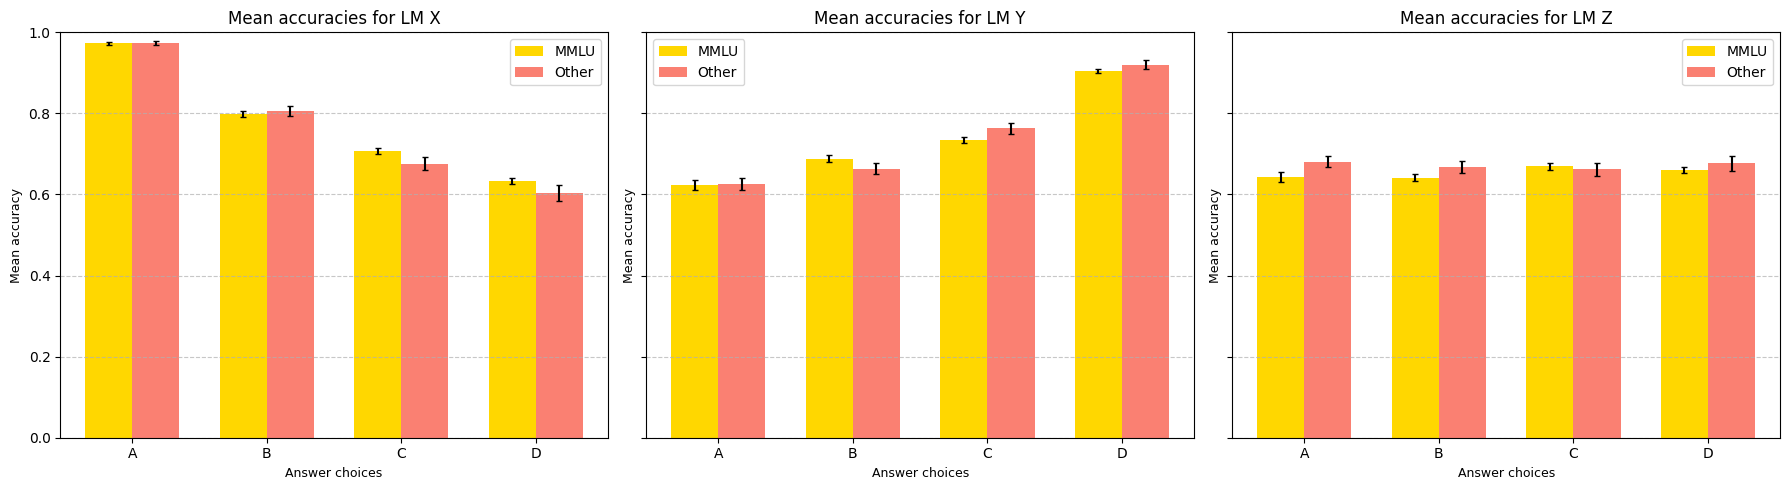

In [2786]:
#A

## PRINT accuracies for ALL LMs for each dataset

answers = ['A', 'B', 'C', 'D']

print('Mean accuracies for all LMS for mmlu dataframe')
#print, for mmlu dataset, the accuracy on the correct answer for all LM for each dataset
for answer in answers:
    answer_mmlu = df_mmlu.loc[df_mmlu['answer'] == answer]
    print(round(answer_mmlu['correct'].sum() / len(answer_mmlu), 4))

print('\nMean accuracies for all LMs for other dataframe')
#print, for other dataset, the accuracy on the correct answer for all LM for each dataset
for answer in answers:
    answer_other = df_other.loc[df_other['answer'] == answer]
    print(round(answer_other['correct'].sum() / len(answer_other), 4))



## PLOT accuracies for EACH LMs for each dataset for more insight and to confirm our hypothesis

# list of all the model options
models = ['X', 'Y', 'Z']

# figure with 3 subplots for better visualisation side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# loop through each model to create the subplots
for i, model in enumerate(models):
    # filter data for the current model
    model_mmlu = df_mmlu.loc[df_mmlu['model_name'] == model]
    model_other = df_other.loc[df_other['model_name'] == model]
    
    # compute mean accuracies and standard deviations to have error bars
    mean_accuracies_mmlu = []
    mean_accuracies_other = []
    errors_mmlu = []
    errors_other = []

    for answer in answers:
        # mmlu dataset
        answer_mmlu = model_mmlu.loc[model_mmlu['answer'] == answer]
        acc_mmlu = answer_mmlu['correct'].sum() / len(answer_mmlu)
        mean_accuracies_mmlu.append(acc_mmlu)
        errors_mmlu.append(np.std(answer_mmlu['correct']) / np.sqrt(len(answer_mmlu)))  # standard erors computation
        
        # other dataset
        answer_other = model_other.loc[model_other['answer'] == answer]
        acc_other = answer_other['correct'].sum() / len(answer_other)
        mean_accuracies_other.append(acc_other)
        errors_other.append(np.std(answer_other['correct']) / np.sqrt(len(answer_other)))  # standard erors computation

    # bar adjustments
    r1 = np.arange(len(answers))
    r2 = [i + bar_width for i in r1]
    bar_width = 0.35

    # plot bars for mnmlu and other dataset
    axes[i].bar(r1, mean_accuracies_mmlu, yerr=errors_mmlu, color='gold', width=bar_width, label='MMLU', capsize=2)
    axes[i].bar(r2, mean_accuracies_other, yerr=errors_other, color='salmon', width=bar_width, label='Other', capsize=2)

    # display labels and titles
    axes[i].set_xlabel('Answer choices', fontsize=9)
    axes[i].set_title(f'Mean accuracies for LM {model}', fontsize=12)
    axes[i].set_xticks([i + bar_width / 2 for i in r1])
    axes[i].set_xticklabels(answers)
    axes[i].grid(axis='y',linestyle='--',alpha=0.7)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel('Mean accuracy', fontsize=9)
    axes[i].legend()

# show the 3 plots
plt.tight_layout()
plt.show()


#### Part B (Discussion)

These results are interesting because in Part A, when we compute the accuracy for model X, we see a clear difference of performance depending on the correct answer. But now, with all LMs combined, we observe that the accuracies are very similar, independently of the correct answer. It means that the other model Y and Z are also biased, and in a way that it equilibrates the total accuracies for all LMs conditioned on the four correct answer. 

A way to confirm this hypothesis was to plot the 3 graphs above that is the accuracy conditioned on the correct answer, for **each** LM. Indeed we notice a skewed distribution for the accuracy of the model X. We observe that the Y model distribution is skewed in the opposite way, and that equilibrates the accuracy for all LM. The Z model doesn't change much the equilibrium.  

### 2.5 (2 pt)

Concerned with your findings so far, you quickly consult with Ms. Sakota. After thinking it over, Ms. Sakota concludes that more tests are needed. She orders a second round of MMLU results. However, the clever Ms. Sakota thinks of the following twist: while keeping questions fixed, she randomly permutes the position of the correct answer. The new results can be found in the folder `data/task_2_5/`:
```
task_2_5/
│
└── lm_scores_mmlu_shuffle.csv
```

**Why would Ms. Sakota do this?**

During training LMs might have learned specific patterns instead of truly understanding the context of the questions. Shuffling could tell if MLs have a deep understanding of the questions and the proposed answers or if they rely on those specific patterns learned during training.

**We saw that the LM choices are not independent (A vs C,D), so changing the position of the correct answer for some questions should impact the LM's accuracy. If it does, it confirms our previous discoveries...**

### 2.6 (4 pt)

Increasingly sceptical of the language models' performance, you read up on proper testing practices. You stumble upon the concept of [test-rested stability](https://en.wikipedia.org/wiki/Repeatability), which roughtly states that:

"_Measurements taken by a single person or instrument on the same item, under the same conditions, and in a short period of time, should have the same results._"

In our case, we would assume an LM would have the same performance on a given question regardless of the correct answer position. One way of testing this is by using the following metric:

$$\text{test-retest metric} = \frac{1}{N}\sum_{i=1}^N \frac{1}{M}\sum_{j=1}^M c^i_0 c_j^i,$$

where $c^i_0 \in \{0, 1\}$ indicates whether the model answers the $i^{\text{th}}$ question correctly (1 if correct, 0 if incorrect). $c_j^i$ indicates whether the model answers the $i^{\text{th}}$ question correctly in the $j^{\text{th}}$ shuffled version of the answer label content. Finally, $M$ is the total number of shuffles and $N$ is the dataset size.

Task: compute the test-retest metric for each language model using the original `lm_scores_mmlu.csv` file and the new `lm_scores_mmlu_shuffle.csv` file. Using a bar plot, visualize your results by comparing the accuracy of the original `lm_scores_mmlu.csv` and the test-retest scores.

**hints**
- what is $M$ in our case?

(bonus: no points, but so much sweet, sweet knowledge - check out [the following article](https://arxiv.org/pdf/2406.19470v1))

Accuracy of X : 
Before shuffle: 0.7436
After shuffle: 0.7831 

Accuracy of Y : 
Before shuffle: 0.7615
After shuffle: 0.7403 

Accuracy of Z : 
Before shuffle: 0.656
After shuffle: 0.666 

Test-retest metric for : X = 0.588, Y = 0.572, Z = 0.442 

If ci0 and cij are the same (shuffle has no impact on response), the test-restest metric should give the accuracy of the LMs.
Here for all LMs, tests < accuracy, so shuffle really has an impact.
We also observe that the shuffle doesnt affect the general accuracies, it means the models correct and wrong answers changes equivalently. The model keeps the same performance.


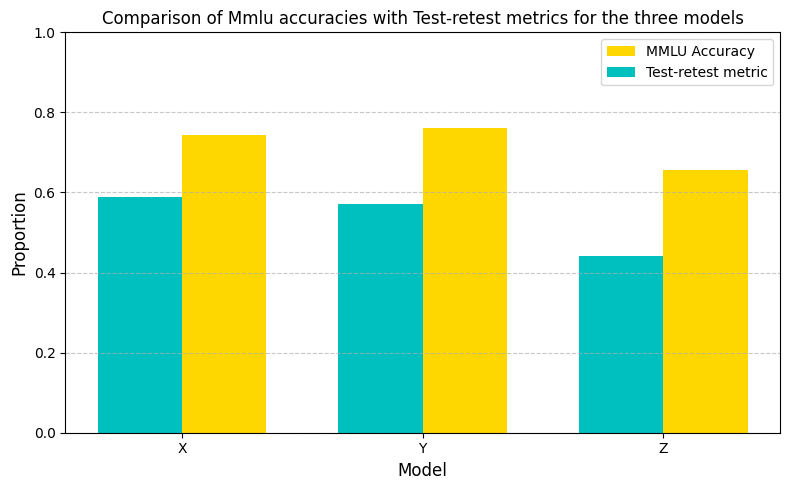

In [2787]:
df_mmlu_shuffle = pd.read_csv('task_2_5/lm_scores_mmlu_shuffle.csv')

# one shuffled version
M = 1
# X
# creating boolean arrays for the model X and the column 'correct', for both shuffled and unshuffled dataset
X_1_0 = np.array(df_mmlu[df_mmlu['model_name'] == 'X']['correct'].astype(int)) 
X_1_0_shuffle = np.array(df_mmlu_shuffle[df_mmlu['model_name'] == 'X']['correct'].astype(int))
N = len(X_1_0)
test_retest_X = 1/N*np.sum(X_1_0*X_1_0_shuffle)
print('Accuracy of X : ')
print('Before shuffle:',round(sum(X_1_0)/N,4))
print('After shuffle:',round(sum(X_1_0_shuffle/N),4),'\n')


# Y
# creating boolean arrays for the model Y and the column 'correct', for both shuffled and unshuffled dataset
Y_1_0 = np.array(df_mmlu[df_mmlu['model_name'] == 'Y']['correct'].astype(int)) 
Y_1_0_shuffle = np.array(df_mmlu_shuffle[df_mmlu['model_name'] == 'Y']['correct'].astype(int))
N = len(Y_1_0)
test_retest_Y = 1/N*np.sum(Y_1_0*Y_1_0_shuffle)
print('Accuracy of Y : ')
print('Before shuffle:',round(sum(Y_1_0)/N,4))
print('After shuffle:',round(sum(Y_1_0_shuffle/N),4),'\n')

# Z
# creating boolean arrays for the model Z and the column 'correct', for both shuffled and unshuffled dataset
Z_1_0 = np.array(df_mmlu[df_mmlu['model_name'] == 'Z']['correct'].astype(int)) 
Z_1_0_shuffle = np.array(df_mmlu_shuffle[df_mmlu['model_name'] == 'Z']['correct'].astype(int))
N = len(Z_1_0)
test_retest_Z = 1/N*np.sum(Z_1_0*Z_1_0_shuffle)
print('Accuracy of Z : ')
print('Before shuffle:',round(sum(Z_1_0)/N,4))
print('After shuffle:',round(sum(Z_1_0_shuffle/N),4),'\n')


# printing the results
print("Test-retest metric for : X = %.3f, Y = %.3f, Z = %.3f" % (test_retest_X,test_retest_Y,test_retest_Z),'\n')
print('If ci0 and cij are the same (shuffle has no impact on response), the test-restest metric should give the accuracy of the LMs.')
print('Here for all LMs, tests < accuracy, so shuffle really has an impact.\nWe also observe that the shuffle doesnt affect the general accuracies, it means the models correct and wrong answers changes equivalently. The model keeps the same performance.')

# collect accuracies before shuffle for each model
accuracy_X = sum(X_1_0) / N
accuracy_Y = sum(Y_1_0) / N
accuracy_Z = sum(Z_1_0) / N

# update the models and their corresponding metrics
models = ['X', 'Y', 'Z']
test_retest_metrics = [test_retest_X, test_retest_Y, test_retest_Z]
accuracies = [accuracy_X, accuracy_Y, accuracy_Z]

# adjust bar positions
plt.figure(figsize=(8, 5))
r1 = np.arange(len(models))
bar_width = 0.35

# bar plot for test-retest metrics and accuracies
plt.bar(r1 + bar_width, accuracies, label='MMLU Accuracy', color='gold', width=bar_width)
plt.bar(r1, test_retest_metrics, label='Test-retest metric',color='c', width=bar_width)

# display labels and titles
plt.title('Comparison of Mmlu accuracies with Test-retest metrics for the three models', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(r1 + bar_width / 2, models)
plt.grid(axis='y',linestyle='--',alpha=0.7)
plt.ylim(0, 1)

# show plot
plt.legend()
plt.tight_layout()
plt.show()


### 2.7 (2 pt)

#### Part A (Code)
Using the unshuffled data: For each LM, print the distribution of the answers they give as well as the accuracy conditioned on the answer they give.

In [2788]:
#A
# accuracies for models X,Y and Z
X = df_mmlu[df_mmlu['model_name']== 'X'].groupby('result')['correct'].mean()
Y = df_mmlu[df_mmlu['model_name']== 'Y'].groupby('result')['correct'].mean()
Z = df_mmlu[df_mmlu['model_name']== 'Z'].groupby('result')['correct'].mean()
data_acc = pd.DataFrame({'X_acc':X,'Y_acc':Y,'Z_acc':Z})

# distribution for models X,Y and Z
dist_X = df_mmlu[df_mmlu['model_name']== 'X']['result'].value_counts()
dist_Y = df_mmlu[df_mmlu['model_name']== 'Y']['result'].value_counts()
dist_Z = df_mmlu[df_mmlu['model_name']== 'Z']['result'].value_counts()
data_dist = pd.DataFrame({'X_dist':dist_X,'Y_dist':dist_Y,'Z_dist':dist_Z})

# merge the two dataframes for better visualizing
data_dist_acc = pd.merge(data_dist,data_acc,left_index=True,right_index=True)

data_dist_acc.head()

,X_dist,Y_dist,Z_dist,X_acc,Y_acc,Z_acc
result,,,,,,
A,4259,1072,2176,0.367927,0.937500,0.476103
B,2659,2256,2885,0.884543,0.897606,0.654073
C,2409,3015,3237,1.000000,0.827861,0.703429
D,2369,5353,3398,1.000000,0.631608,0.727487


#### Part B (Discussion)
**Describe what you observe**

We observe that the accuracies and the distributions are not equal at all for the different answer options. For model X, it answers A most of the time but its accuracy is low (36%),while it has perfect accuracies for answer C and D,which it doesn't choose a lot. For model Y, the accuracy is the worst for the most chosen option too (D). Model Z seems more equilibrated on his options choice, and for the accuracies too. This behavior let us think that the models (X and Y at least)are biased on their answers, as they chose more answer A and D (respectively), and this with a poor accuracy.  In 2.3A, we saw that the model X had a great accuracy when the correct answer was A, we understand it now when we see that the model answers a lot A, and answers C,D and B too, only when it's sure that they are the correct answers. Moreover, in 2.2A, we see that the answer A is hardly ever the correct one. So it confirms the accuracy in 2.3A too.

**[bonus: not scored, but again _that sweet, sweet knowledge_] Could you think of a plausible explanation?**

It could be possible that models X and Y have learned to prefer certain types of response. A reason for this could be an unbalance in the training data. Indeed, if the dataset to train the LM had more questions with, let’s say,  ‘A’ or ‘D’ as the correct answer, the LMs could have developed a preference to choose these answers (‘A’ or ‘D’). 
This could then result in lower accuracy for the LMs. This can be seen on model X which prefers A (4259 > the others ~2500) but whose accuracy is low for this option (0.36 < 0.9-1.0 for others).

## Task 3 (16 points): What do Questions and Answers look like for a Language Model?

While you feel pretty good about the tests you conducted so far, something still bothers you: what if the language models don't see the data like you do? Suddenly, you receive a phone call from a wise AI sage in the West, _Westoda_:

```
"Hmm, correct you are, young padawan, to question how the world is seen by large language models! Simple 'text' it is not, hmm? No, no, no! Characters and words, the way of puny humans, this is not, heh heh heh.

'Tokens', they use, yes! Mysterious and powerful, these tokens are. Expand our vocabulary, they do, beyond the simple 'a to Z'. Chunky blocks of text, they become, yes! 'Hello world', a simple phrase it may seem. But to a language model, '[24912, 2375]' it might appear, yes! Confusing, it is, hmm?

Wise, it would be, to explore these MMLU data points through the eyes of a language model, you think? Yes, yes! Much to learn, there is. The ways of the tokens, understand you must, if truly comprehend the great LMs, you wish to.
Meditate on this, you should. The force of natural language processing, strong it is. But patience, you must have, my young padawan. For only through great study and contemplation, will the mysteries of the tokens reveal themselves to you, they will. Yes, hmmm!"
```

Admittingly, Westoda at times speaks in riddles… However, he was explaining a crucial aspect of modern LMs called [Tokenization](https://learn.microsoft.com/en-us/dotnet/ai/conceptual/understanding-tokens):


“Tokens are words, character sets, or combinations of words and punctuation that are used by [language models (LMs)] to decompose text into. Tokenization is the first step in training”

Instead of characters, LMs process natural language using “tokens”. While this is useful for a number of reasons, it does at times introduce some “unintuitive” behavior…

In [2789]:
# PROVIDED CODE

try:
    import tiktoken
except ImportError:
    print('Installing tiktoken package...')
    import pip
    pip.main(['install', 'tiktoken'])
    import tiktoken

def tokenize_text(s):
    enc = tiktoken.encoding_for_model('gpt-4o') 
    tokens = enc.encode(str(s))
    return tokens

example_string = 'hello world'
print(f'humans see: "{example_string}" --> language models see: {tokenize_text(example_string)}')

humans see: "hello world" --> language models see: [24912, 2375]


In [2790]:
# function to decode tokens back into human-readable text
def detokenize_text(tokens):
    enc = tiktoken.encoding_for_model('gpt-4o')
    text = enc.decode(tokens)
    return text

### 3.1 (5 pt)

Use the provided code in the cell above to "see the world through the eyes of a language model":

**hint**
- There are a _lot_ of tokens, consider using a cutoff point and log scale
- For (c), they should sum to 1

#### Part A (Code)
Tokenize the questions of the original MMLU data provided in task 1: `task_1/mmlu_data/test.csv` and plot the token distribution (the frequency of each token).

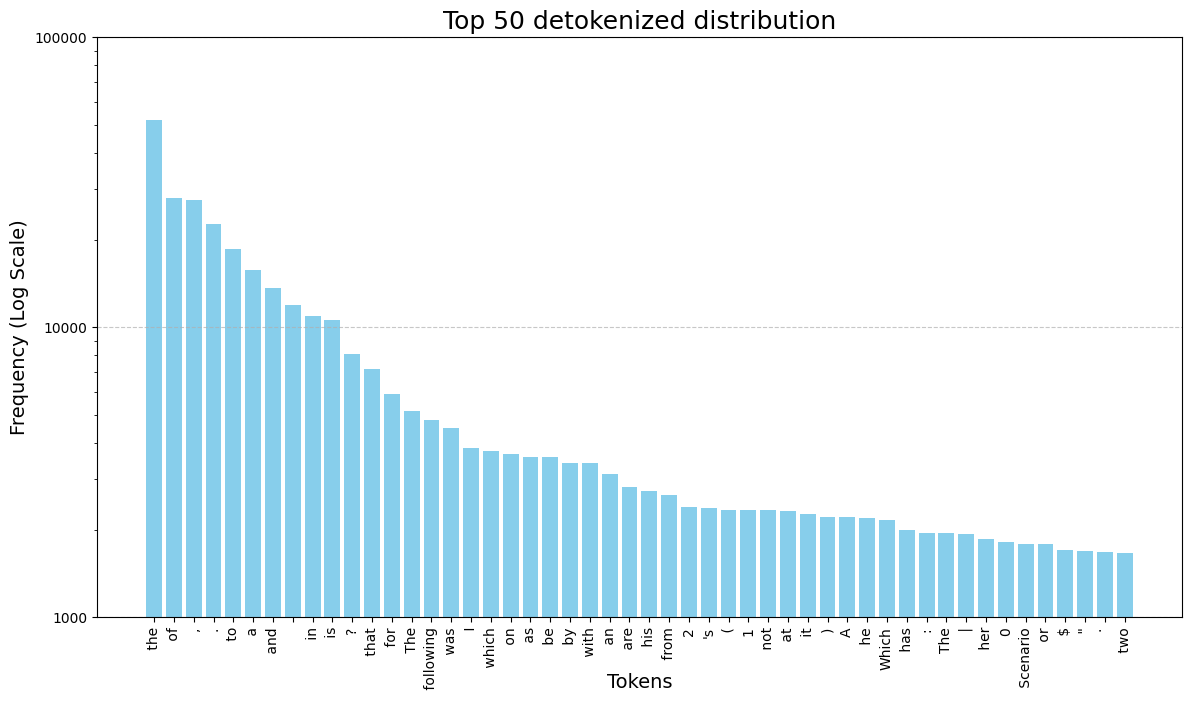

In [2791]:
# A
from collections import Counter as ct

# function that take a DataFrame as input and a field and tokenize the content of the column
def generate_tocken_distribution(df, fields, top_number=-1):

    # if not precised, take all the token for the distribution
    if top_number == -1:
        top_number = len(df)
    
    # tokenization of the questions
    tokens = []
    for field in fields:
        for question in df_mmlu[field]:
            tokens.extend(tokenize_text(question))
    
    # create the count mapping : "token" -> "count" and take only the "top_number" token
    token_counts = ct(tokens)
    top_tokens_count = token_counts.most_common(top_number)
    
    # generating the distribution
    top_tokens = [token for token, _ in top_tokens_count]
    frequencies = [freq for _, freq in top_tokens_count]
    enc = tiktoken.encoding_for_model('gpt-4o')
    decoded_tokens = [enc.decode([token]) for token in top_tokens]
    token_distribution = pd.DataFrame({'Token': decoded_tokens, 'Frequency': frequencies})

    # return the distribution of the tokens
    return token_distribution

# function that take a distribution and plot it with a log scale
def ploting_distribution(token_distribution):

    # define the plot parameters
    plt.figure(figsize=(14, 10))
    plt.bar(token_distribution['Token'].astype(str), token_distribution['Frequency'], color='skyblue')
    plt.title("Top " + str(len(token_distribution['Token'])) + " detokenized distribution", fontsize=18)

    # manage the axis
    plt.xlabel('Tokens', fontsize=14, labelpad=-15)
    plt.ylabel('Frequency (Log Scale)', fontsize=14)
    plt.yscale('log')
    plt.xticks(rotation=90, ha='center')
    plt.subplots_adjust(bottom=0.3)
    y_ticks = [1000, 10000, 100000]  # Add more tick marks for granularity
    plt.yticks(y_ticks, labels=[str(tick) for tick in y_ticks])
    
    # show the plot
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# define the parameters
top_number = 50 # change this number to see more
df_mmlu = pd.read_csv('task_1/mmlu_data/test.csv')

# tokenization of the Dataframe with the "question" field
token_distribution = generate_tocken_distribution(df_mmlu, ["question"], top_number)

# ploting the distribution
ploting_distribution(token_distribution)


#### Part B (Code)
Same as (A), but now for the answers in columns (columns "A", "B", "C", and "D").

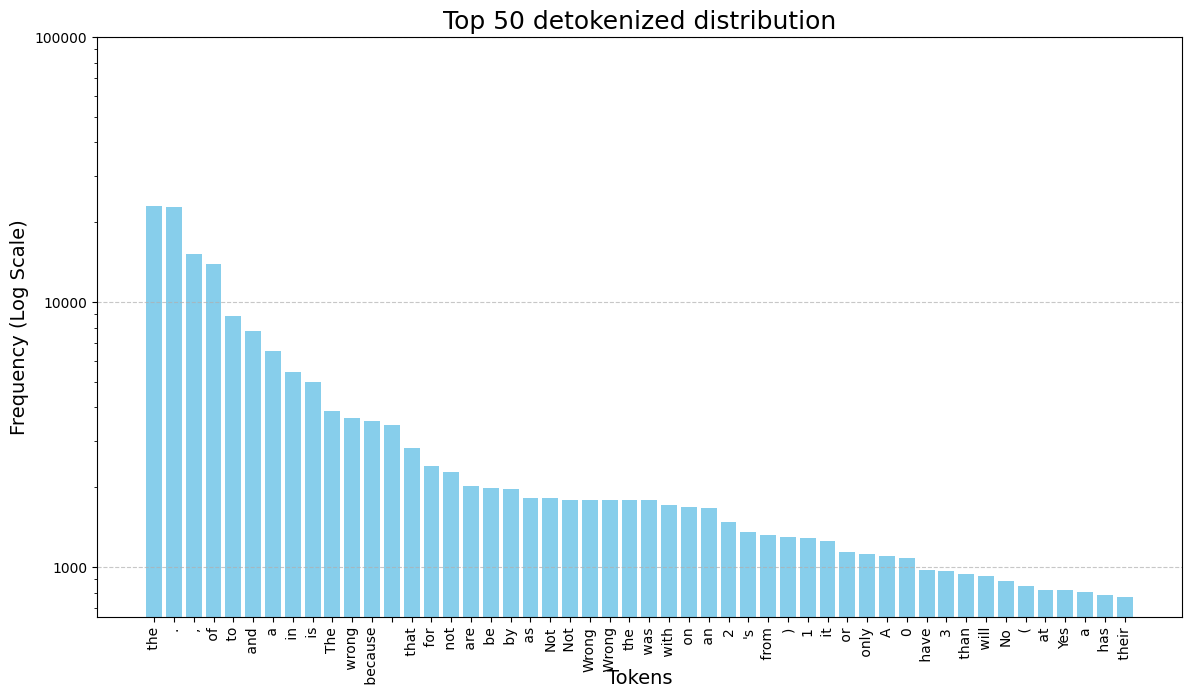

In [2792]:
#B
# define the parameters
top_number = 50 # change this number to see more
df_mmlu = pd.read_csv('task_1/mmlu_data/test.csv')

# tokenization of the dataframe with the "A", "B", "C", "D" fields
token_distribution = generate_tocken_distribution(df_mmlu, ["A", "B", "C", "D"], top_number)

# ploting the distribution
ploting_distribution(token_distribution)

#### Part C (Code)
Isolate the tokens for the strings "A", "B", "C", and "D", then, for their occurances in both questions and answers, print their relative distribution to each other.

In [2793]:
#C

# extract the text data from columns 'A', 'B', 'C', and 'D'
text_A = df_mmlu['A']
text_B = df_mmlu['B']
text_C = df_mmlu['C']
text_D = df_mmlu['D']

# combine all the text from the answers to one series 
text_answers = pd.concat([text_A, text_B, text_C, text_D])

# empty list to hold tokens from answers
tokens_list_answers = []

# tokenize each answer and extend the list with tokens 
for answer in text_answers:
    tokens_list_answers.extend(tokenize_text(answer))

# count occurrances of each token in the answer text
token_counts_answers = ct(tokens_list_answers)

# empty list to hold tokens from the questions 
tokens_list_questions = []

# tokenize each question and extend the list with tokens
for question in df_mmlu['question']:
    tokens_list_questions.extend(tokenize_text(question)) 

# count occurrances of each token in the question text
token_counts = ct(tokens_list_questions)

# tokenize characters 'A', 'B', 'C', 'D' 
A_t = tokenize_text('A') 
B_t = tokenize_text('B')
C_t = tokenize_text('C')
D_t = tokenize_text('D') 

# combine all tokens from questions and answers into one big list
all_tokens = tokens_list_questions + tokens_list_answers

# counters for occurrances of 'A', 'B', 'C', 'D' tokens
A_t_count = 0
B_t_count = 0
C_t_count = 0
D_t_count = 0

# loop through all tokens and count occurrences of 'A', 'B', 'C', and 'D'
for token in all_tokens:
    if token == A_t[0]: # checks if token matches with 'A' token
        A_t_count += 1
    elif token == B_t[0]: # same for B
        B_t_count += 1
    elif token == C_t[0]: # same for C
        C_t_count +=1
    elif token == D_t[0]: # same for D
        D_t_count += 1

# compute total count of 'A', 'B', 'C', 'D' tokens
total_count = A_t_count + B_t_count + C_t_count + D_t_count

# display total occurrences of 'A', 'B', 'C', 'D' tokens
print('Total occurrances of "A" token : ', A_t_count)
print('Total occurrances of "B" token : ', B_t_count)
print('Total occurrances of "C" token : ', C_t_count)
print('Total occurrances of "D" token : ', D_t_count)

# display relative distribution of 'A', 'B', 'C', 'D' tokens
print('\nRelative distribution of "A" token : ', round(A_t_count/total_count, 3))
print('Relative distribution of "B" token : ', round(B_t_count/total_count, 3))
print('Relative distribution of "C" token : ', round(C_t_count/total_count, 3))
print('Relative distribution of "C" token : ', round(D_t_count/total_count, 3))


Total occurrances of "A" token :  3314
Total occurrances of "B" token :  252
Total occurrances of "C" token :  425
Total occurrances of "D" token :  195

Relative distribution of "A" token :  0.792
Relative distribution of "B" token :  0.06
Relative distribution of "C" token :  0.102
Relative distribution of "C" token :  0.047


### 3.2 (3 pt)

What if the number of "A", "B", "C", and "D" tokens in the question and answer pairs could influence a language model's decisions?

#### Part A (Code)
For each combined question-answers pair, compute: 
1. the number of "A", "B", "C", and "D" tokens; and
2. the total number of tokens.
3. then, group by the "correct" answer and compute the mean frequency of A, B, C, and D tokens and the total number of tokens. 
4. finally, print your results

In [2794]:
#A

# make a new dataframe with only the 'question', 'A', 'B', 'C', and 'D' columns from df_mmlu
question_answers_pair = df_mmlu[['question', 'A', 'B', 'C', 'D']]

# array to store token counts for A, B, C, D, and the total tokens
array_tokens = np.zeros((question_answers_pair.shape[0],5))

# itterate on each row (question + answers) of the new dataframe
for i in range(question_answers_pair.shape[0]):

    # tokenize the question, 'A', 'B', 'C', and 'D' columns
    tokens_question_answers_pair = tokenize_text(question_answers_pair.iloc[i].values)

    # count the occurrances of tokens 'A', 'B', 'C', 'D' and count the total tokens
    for token in tokens_question_answers_pair:
        if token == A_t[0]:     # check if token is 'A' and add one to its counter
            array_tokens[i,0] += 1
        if token == B_t[0]:     # same for B
            array_tokens[i,1] += 1
        if token == C_t[0]:     # same for C
            array_tokens[i,2] += 1
        if token == D_t[0]:     # same for D
            array_tokens[i,3] += 1

        # increment the total token counter by 1
        array_tokens[i,4] += 1

# create boolean arrays to show which rows have the correct answer as A, B, C, D
rows_where_answer_is_A = np.array(df_mmlu['answer']=='A')
rows_where_answer_is_B = np.array(df_mmlu['answer']=='B')
rows_where_answer_is_C = np.array(df_mmlu['answer']=='C')
rows_where_answer_is_D = np.array(df_mmlu['answer']=='D')

# select token counts for rows where the correct answer is 'A', 'B', 'C', 'D'
array_tokens_answer_A = array_tokens[rows_where_answer_is_A]
array_tokens_answer_B = array_tokens[rows_where_answer_is_B]
array_tokens_answer_C = array_tokens[rows_where_answer_is_C]
array_tokens_answer_D = array_tokens[rows_where_answer_is_D]

# compute the token counts for each answer
A_token_c = np.sum(array_tokens_answer_A, axis=0) / array_tokens_answer_A.shape[0]
B_token_c = np.sum(array_tokens_answer_B, axis=0) / array_tokens_answer_B.shape[0]
C_token_c = np.sum(array_tokens_answer_C, axis=0) / array_tokens_answer_C.shape[0]
D_token_c = np.sum(array_tokens_answer_D, axis=0) / array_tokens_answer_D.shape[0]

# create a new dataframe with the computed values for easier display and understanding
# For example the number on first row, first column will be : The average number of tokens ‘A’ in a question-answer pair when the correct answer is A
df_token_c = pd.DataFrame([A_token_c, B_token_c, C_token_c, D_token_c],
                               columns=['Mean A_t frequency,', 'Mean B_t frequency', 'Mean C_t frequency', 'Mean D_t frequency', 'Mean token count'],
                               index=['Correct Answer is A', 'Correct Answer is B', 'Correct Answer is C', 'Correct Answer is D'])

# display the new dataframe
df_token_c


,"Mean A_t frequency,",Mean B_t frequency,Mean C_t frequency,Mean D_t frequency,Mean token count
Correct Answer is A,0.244258,0.019553,0.025450,0.013346,102.283675
Correct Answer is B,0.231947,0.019642,0.029463,0.012709,97.884749
Correct Answer is C,0.227527,0.018984,0.034338,0.015355,101.724456
Correct Answer is D,0.244174,0.014831,0.030985,0.014566,101.277278


#### Part B (Discussion)
**What do you think of the hypothesis that the frequency of A, B, C, and D tokens could influence answers?**
The table shows that the average frequencies of tokens ‘A’, ‘B’, ‘C’ and ‘D’ vary very little for the different correct answers. We can see : 
- column 1 : values between ~$0.23$ and $0.24$ (no big change across the correct Answers)
- column 2 : values between ~$0.014$ and $0.019$ (little change)
- column 3 : values between ~$0.025$ and $0.034$ (also little change)
- column 4 : values between ~$0.012$ and $0.015$ (also little change)

This means that the influence of token frequency on responses is possible but if it is, it's very minimal. Also very little differences on the mean token count (around ~$100$).
Thus, we see the hypothesis is wrong and that there is no clear and strong trend that shows that token frequency affects in a significant manner the probability of a specific response being correct.

Also, we can see that 'A' is more frequent (~0.2 for A vs ~0.02 for B,C,D), this is probably due to sentences beginning with the determinant "A" like "A cat is..." and also the fact that A is a vowel meaning it might be more frequent.

### 3.3 (4 pt)

Three of the most important considerations when deciding between language models are:

Quality
Costs
Speed

So far, much of your analysis has focused on quality. However, the government has indicated that they are quite concerned about both the total costs and speed as well. Specifically, it has been brought to their attention that a new `turbo` model has been launched! 

This model is both cheaper and faster than the models you evaluated so far. However, there is a catch: the context length* is much smaller than that of the other LMS. Namely, it can only process **300** tokens during inference. Meanwhile, the other models can process up to 100K tokens! 

*_The “context length” refers to the number of tokens that can be given to an LM as input._

**hint**:
- An LM needs to have both the question and the different answer options in its context

#### Part A (Code)
**Are there subjects where using the cheaper model might be problematic? I.e., where part of the question and answer(s) might not fit completely in the context?**


In [2795]:
#A
# asking the LM a question and giving it the proposed answers requires a clear format, which adds some more tokens
additional_tokens = tokenize_text('\nA. \nB. \nC.\nD. ')

# see rows where the total number of tokens (on column 4, from previous code question) is >300
rows_with_more_than_300_tokens = array_tokens[:,4] + len(additional_tokens)>300

# gets the 'subject' column from df_mmlu
subjects_col = df_mmlu['subject']

# filters the subjects column where the total token count is >300
subjects_with_more_than_300_tokens = subjects_col[rows_with_more_than_300_tokens]

# counts the occurrances of each subject with >300 tokens 
subjects_ct = ct(subjects_with_more_than_300_tokens)

# conversion of the counter into a dataframe for nicer display
subject_counts_df = pd.DataFrame(list(subjects_ct.items()), columns=['Subject', 'Count'])

# sort dataframe by count 
subject_counts_df = subject_counts_df.sort_values(by='Count', ascending=False)

# display it
subject_counts_df

,Subject,Count
6,professional law,421
5,high school world history,149
4,high school us history,124
2,high school european history,103
7,professional medicine,20
8,security studies,9
0,college medicine,5
1,high school computer science,1
3,high school statistics,1
9,virology,1


#### Part B (Discussion)
**Can you think of a strategy that would balance the needs of the government?**

There are several strategies that can be applied. For instance, an easy way would be to run the turbo model only on subject that have no excessive context length. Better even, to run it only on questions that have high context length. That would represent only 750 questions, instead of the original 14042 questions. 

Another possible way to explore is to pre-process the questions and answers, so that the context length is reduced. For example one could remove (if it does not impact the result), some "useless" tokens, such as "the", "or", etc. Those words mostly impact the number of token, without providing any added information on the question/answer. One can also run an algorithm to simplify some tokens. For example 'USA' is one token, but 'U.S.A' is three. 

### 3.4 (4 pt)

The time has come to give your final recommendation on the use of LMs in education to the government! Taking into account everything you analyzed in all the preceding tasks (1, 2, and 3), please write a short recommendation consisting of 4 bullet points discussing your concerns.

**hint**
- Try to use the MECE framework: _Mutually Exclusive Collectively Exhaustive_

**Discussion**

1. ⁠Firstly we recommend to always keep in mind that the Languages Models can't be assurate to give you all the results in the same format you expect (seen in Part 1.2 A, when displaying the value_counts). It is essential to remember that the generated answers may require adjustments to exactly match the needs.

2. As we have seen during the third part of the homework, Language Models have some bias. Some models are more likely to give a certain type of answers than others. During the third part, we have studied a particular bias coming from the presence of specific tokens in the quesion-answer pairs, but there are many other reasons that can skew the results, and they are often unidentifiable precisely. The bias comes from the training data and from the manner the models were learned.

3. ⁠It can happend that the answer that is choosen by the models is influenced by the order in which the answers are provided. We have seen this particularity in the part 2 of the homework when the answers's shuffle was made. Indeed, with the shuffle we have observed that the models no longer answered the same questions in the same way. We put forward the hypothesis that this order-dependent particularity comes from human ability to assign some pattern to correct answer positioning in the training question-answers pair.

    It could make sense for the models to use this kind of influence if the training and testing question-answers pair are generated in the same manner. But it becomes a bad influence if the order of the answers at testing time are randomized. This must be taken into account when choosing the model in relation to the needs of the government.

4. The last recommendations is to use different LMs for different subjects. Indeed, during our analysis (**_Part 2.1 B & C_**), we saw that some LMs might perform better when asked questions on different subjects (different datasets of questions). When using LMs for education, it might be better to have a Math specialised LM for Maths, an History specialised for History etc.. 

    We also saw (**_Part 1.5 A_**) that there was an unbalance on the **discarded** subjects because too long answers (>10) got discarded. This uneven distribution of long answers (that get discarded) might also happen because some LMs are more specialised in certain subjects and thus prefer to give a more nuanced and precise answer on the subjects they are specialised in.